In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw, QED, Descriptors, AllChem
from rdkit import DataStructs
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [24]:
def load_smiles_dataset(file_path):
    """Load the dataset containing SMILES representations."""
    try:
        smiles_data = pd.read_csv(file_path)
        print(f"Dataset loaded successfully with {len(smiles_data)} molecules.")
        return smiles_data
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None
    
def preprocess_smiles(smiles_list):
    """Convert SMILES strings into numerical representations for model training."""
    # Add start and end tokens to each SMILES string
    processed_smiles = ['<' + s + '>' for s in smiles_list]
    
    # Create a character set from all SMILES strings
    all_chars = set()
    for smiles in processed_smiles:
        all_chars.update(smiles)
    
    # Create mapping dictionaries
    char_to_idx = {c: i for i, c in enumerate(sorted(all_chars))}
    idx_to_char = {i: c for i, c in enumerate(sorted(all_chars))}
    
    # Get maximum length for padding
    max_length = max(len(s) for s in processed_smiles)
    
    # Create input and target sequences for training
    X = []
    y = []
    
    for smiles in processed_smiles:
        # Convert characters to indices
        char_indices = [char_to_idx[c] for c in smiles]
        
        # Create input-target pairs for each position
        for i in range(1, len(char_indices)):
            X.append(char_indices[:i])
            y.append(char_indices[i])
    
    # Pad sequences to the same length
    X_padded = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_length-1, padding='pre')
    
    # One-hot encode the target values
    y_onehot = to_categorical(y, num_classes=len(char_to_idx))
    
    return X_padded, y_onehot, char_to_idx, idx_to_char, max_length

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Attention, Embedding
from tensorflow.keras.models import Sequential

def create_model(vocab_size, max_length):
    model = Sequential([
        Embedding(vocab_size, 64, input_length=max_length-1),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(128),
        Dense(vocab_size, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import SanitizeFlags

def generate_molecule(seed_char, model, char_to_idx, idx_to_char, max_length, temp=1.0, max_retries=3):
    """Generate a valid molecule with enhanced chemical constraints."""
    valid_chars = {'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 
                  '=', '#', '(', ')', '[', ']', '@', '-', '+', '\\', '/', '.'}
    
    for _ in range(max_retries):
        generated = seed_char
        valid = True
        
        for i in range(max_length):
            # Convert sequence to model input
            x_pred = np.zeros((1, max_length-1))
            for t, char in enumerate(generated):
                if t < max_length-1:
                    x_pred[0, t] = char_to_idx.get(char, 0)  # Handle unknown chars

            # Get predictions and apply temperature
            preds = model.predict(x_pred, verbose=0)[0]
            preds = np.log(np.clip(preds, 1e-10, None)) / temp
            exp_preds = np.exp(preds)
            preds = exp_preds / exp_preds.sum()

            # Mask invalid characters
            valid_indices = [i for i, c in idx_to_char.items() if c in valid_chars or c in ['<', '>']]
            mask = np.zeros_like(preds)
            mask[valid_indices] = 1
            masked_preds = preds * mask
            if masked_preds.sum() == 0:
                valid = False
                break
            masked_preds /= masked_preds.sum()

            # Sample next character
            next_idx = np.random.choice(len(masked_preds), p=masked_preds)
            next_char = idx_to_char.get(next_idx, '')
            
            # Check for chemical constraints
            if next_char not in valid_chars and next_char not in ['<', '>']:
                valid = False
                break

            generated += next_char

            # Early stopping check
            if next_char == '>':
                break

        # Process generated molecule
        molecule = generated.replace('<', '').replace('>', '')
        
        # Validate with RDKit using strict sanitization
        mol = Chem.MolFromSmiles(molecule, sanitize=False)
        if mol:
            try:
                Chem.SanitizeMol(mol, sanitizeOps=SanitizeFlags.SANITIZE_ALL)
                return molecule  # Return valid molecule
            except:
                continue  # Retry if sanitization fails
                
    return None  # Return None after max retries


In [36]:
# 5. Validate generated molecules
def validate_molecules(smiles_list):
    """Check if generated SMILES strings represent valid molecules."""
    valid_mols = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_mols.append((smiles, mol))
    
    return valid_mols

def calculate_properties(valid_molecules, training_mols):
    """Calculate properties and similarity metrics for the generated molecules."""
    results = []
    
    # Create fingerprints for training molecules
    training_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) 
                   for mol in training_mols]
    
    for smiles, mol in valid_molecules:
        # Calculate basic properties
        mol_weight = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        qed_score = QED.qed(mol)
        
        # Calculate similarity to training set
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
        similarities = [DataStructs.TanimotoSimilarity(fp, train_fp) 
                       for train_fp in training_fps]
        max_similarity = max(similarities)
        avg_similarity = sum(similarities) / len(similarities)
        
        results.append({
            'SMILES': smiles,
            'MolWeight': mol_weight,
            'LogP': logp,
            'TPSA': tpsa,
            'QED': qed_score,
            'MaxSimilarity': max_similarity,
            'AvgSimilarity': avg_similarity
        })
    
    return pd.DataFrame(results)

In [37]:
num_molecules = 100
file_path = "Data_for_GenAI.csv"
data = load_smiles_dataset(file_path)
data = data[['Unnamed: 1']].rename(columns={'Unnamed: 1': 'SMILES'})
data.head()

Dataset loaded successfully with 3000 molecules.


,SMILES
0,Ic1ccc(nc1)Cc1cccc(c1)Cc1ccc(cn1)N1C(=O)c2c(C1...
1,Ic1ccc(nc1)Cc1ccc2c(c1)cc(cc2)Cc1ccc(cn1)N1C(=...
2,O=C1c2cc(ccc2C(=O)N1c1ccc(c(c1Cl)Cl)S(=O)(=O)c...
3,Ic1cc(cc(c1)C(=O)O)C(=O)c1ccc2c(c1)ccc(c2)C(=O...
4,Clc1cc(cc(c1)C(C(F)(F)F)(C(F)(F)F)c1c(C)cc(cc1...


In [38]:
def train_model(model, X_train, y_train, X_val, y_val):
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.01),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ]

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=128,
        validation_data=(X_val, y_val)
    )
    return history


In [39]:
smiles_list = data['SMILES'].tolist()
X, y, char_to_idx, idx_to_char, max_length = preprocess_smiles(smiles_list)
vocab_size = len(char_to_idx)
print(vocab_size)
print(max_length)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the model
model = create_model(vocab_size, max_length)
model.summary()



21
165


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/50


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 21), output.shape=(None, 21)

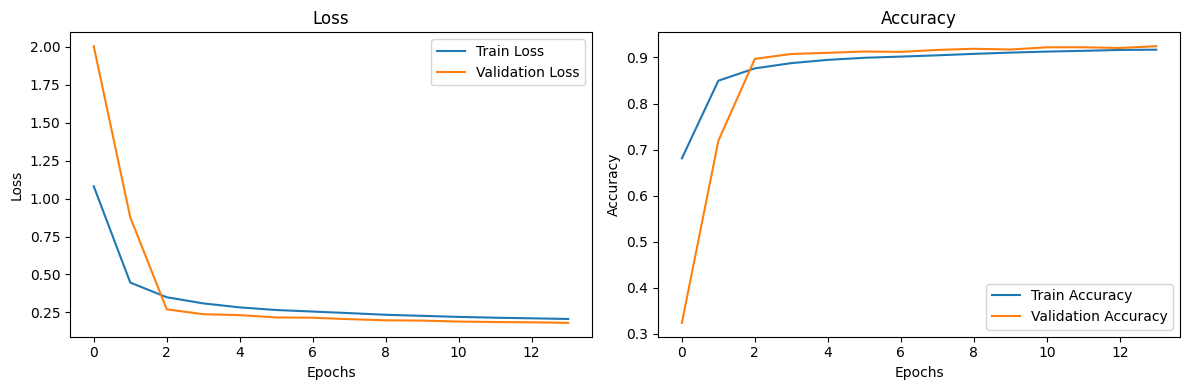

In [71]:
#plotting the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
print("generating new molecules...")
generated_smiles = set()

training_mols = [Chem.MolFromSmiles(s) for s in smiles_list if Chem.MolFromSmiles(s) is not None]
pbar = tqdm(total=num_molecules)
while len(generated_smiles) < num_molecules:
    new_mol = generate_molecule('<', model, char_to_idx, idx_to_char, max_length, temp=0.5)
    
    
    if new_mol:
        mol = Chem.MolFromSmiles(new_mol)
        if (mol and new_mol not in generated_smiles and new_mol not in smiles_list and all(not mol.HasSubstructMatch(train_mol) for train_mol in training_mols)):
            generated_smiles.add(new_mol)
            pbar.update(1)
pbar.close()

generating new molecules...


  0%|          | 0/100 [08:08<?, ?it/s]
[19:22:04] SMILES Parse Error: extra close parentheses while parsing: COIFOFOOOOFFFFOOOOFFCIFOFOOFOFOOFOOFOFFICOFOCFFFOOOFFFOOCOOOFFFFFOFOOOOOOFOOOOOOFOOOFFCOFFFFCOOFFFOFOFOOOFFOOFOOOFFFFOFFFFOOFFFFFFFFFFFFFFFFFFFOFFFFFFFFFFFFFFF)C=O))
[19:22:04] SMILES Parse Error: check for mistakes around position 160:
[19:22:04] FFFFOFFFFFFFFFFFFFFF)C=O))
[19:22:04] ~~~~~~~~~~~~~~~~~~~~^
[19:22:04] SMILES Parse Error: Failed parsing SMILES 'COIFOFOOOOFFFFOOOOFFCIFOFOOFOFOOFOOFOFFICOFOCFFFOOOFFFOOCOOOFFFFFOFOOOOOOFOOOOOOFOOOFFCOFFFFCOOFFFOFOFOOOFFOOFOOOFFFFOFFFFOOFFFFFFFFFFFFFFFFFFFOFFFFFFFFFFFFFFF)C=O))' for input: 'COIFOFOOOOFFFFOOOOFFCIFOFOOFOFOOFOOFOFFICOFOCFFFOOOFFFOOCOOOFFFFFOFOOOOOOFOOOOOOFOOOFFCOFFFFCOOFFFOFOFOOOFFOOFOOOFFFFOFFFFOOFFFFFFFFFFFFFFFFFFFOFFFFFFFFFFFFFFF)C=O))'
[19:22:10] SMILES Parse Error: syntax error while parsing: OOFOOOFIFOOFOIOFCOFFOFFOOCFOOFOOFFOOOFFFCOOFOOOOOOFOOOOOFFOFFOOOOFFFIOOOOOOOFFFOOFFOFFOFFFOFFFIOFFOOOOFOOOFFOFOOFOFFFFFOFFF

KeyboardInterrupt: 

In [ ]:
valid_molecules = validate_molecules(list(generated_smiles))
print(f"Generated {len(valid_molecules)} valid molecules out of {num_molecules} attempts")

In [ ]:
results_df = calculate_properties(valid_molecules, training_mols)
results_df.to_csv('generated_molecules.csv', index=False)
if len(valid_molecules) > 0:
        mols_to_draw = [mol for _, mol in valid_molecules[:10]]
        img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(200, 200))
        img.save('generated_molecules.png')

In [ ]:
print("Top 10 generated molecules:")
print(results_df.head(10))